## Predicting Elections

Predict whether a candidate will win or lose

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Import data

Import all data from Step 1 models and other features

In [ ]:
df0 = pd.read_excel('election_result.xlsx') #Election Result
df1 = pd.read_csv('fb_topics_metrics.csv') #Number of facebook posts & reactions, probabilites of each topic
df2 = pd.read_csv('PersonalityScores/AudienceScores_Percentiles.csv') #Audience OCEAN score
df3 = pd.read_csv('PersonalityScores/[For Processing] PersonalityScores_Percentiles.csv') #Candidate OCEAN score
df4 = pd.read_csv('PersonalityScores/AudienceScores_Raw.csv') #Audience OCEAN raw score
df5 = pd.read_csv('PersonalityScores/[For Processing] PersonalityScores_Raw.csv') #Candidate OCEAN raw score
df6 = pd.read_csv('agg_candidate.csv') #Number of tweets, retweets, replies, favorites, share of voice, political party
df7 = pd.read_csv('SentimentAnalysis_TB_LinearSVC.csv') #sentiment results from LinearSVC
df8 = pd.read_csv('SentimentAnalysis_TB.csv') #sentiment results from TextBlob

Select columns

In [ ]:
df2 = df2.loc[:, ['Candidate','Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional range']]
df3 = df3.loc[:, ['Candidate','Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional range']]
df4 = df4.loc[:, ['Candidate','Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional range']]
df5 = df5.loc[:, ['Candidate','Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional range']]

In [ ]:
df1 = df1.loc[:, ['Candidate', 'NumReactions', 'NumPosts', 'Topic 0',\
                'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8']]

In [ ]:
df7 = df7.loc[:, ['Candidate', '%_Pos', '%_Neu', '%_Neg']]
df8 = df8.loc[:, ['Candidate', '%_Pos', '%_Neu', '%_Neg']]

In [ ]:
df6.rename(columns={'candidate':'Candidate'},inplace=True)
df6 = df6.drop(columns=['#', 'political_party'])

In [ ]:
df6

,Candidate,tweets,users,favorites,retweets,replies,news_pct,nonnews_pct,voice_share,AKSYON,...,MKBYN,NP,NPC,PDPLBN,PDSP,PFP,PLM,PMP,UNA,WPP
0,Vangie Abejo,13,13,118,102,7,0.000000,1.000000,0.000050,0,...,0,0,0,0,0,0,0,0,0,0
1,Abner Afuang,199,112,656,200,105,0.105528,0.894472,0.000768,0,...,0,0,0,0,0,0,0,0,0,1
2,Freddie Aguilar,1701,1157,46909,6913,1030,0.019400,0.980600,0.006567,0,...,0,0,0,0,0,0,0,0,0,0
3,Shariff Albani,119,45,317,122,67,0.243697,0.756303,0.000459,0,...,0,0,0,0,0,0,0,0,0,1
4,Gary Alejano,10837,3776,211122,54493,11277,0.020670,0.979330,0.041837,0,...,0,0,0,0,0,0,0,0,0,0
5,Richard Alfajora,56,24,132,53,37,0.000000,1.000000,0.000216,0,...,0,0,0,0,0,0,0,0,0,0
6,Raffy Alunan,1861,709,10398,2255,1190,0.012359,0.987641,0.007185,0,...,0,0,0,0,0,0,0,0,0,0
7,Sonny Angara,21352,5704,127505,24801,13976,0.012786,0.987214,0.082431,0,...,0,0,0,0,0,0,0,0,0,0
8,Bam Aquino,11690,5395,160642,38127,9104,0.026689,0.973311,0.045130,0,...,0,0,0,0,0,0,0,0,0,0
9,Gerald Arcega,97,41,200,55,86,0.360825,0.639175,0.000374,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df2.columns = ['AudPerc_' + x if x!='Candidate' else x for x in df2.columns.values]
df3.columns = ['CandPerc_' + x if x!='Candidate' else x for x in df3.columns.values]
df4.columns = ['AudRaw_' + x if x!='Candidate' else x for x in df4.columns.values]
df5.columns = ['CandRaw_' + x if x!='Candidate' else x for x in df5.columns.values]

In [ ]:
df1.loc[1,'Candidate'] = 'Doc Willie Ong' #change name to match other dfs
df3.loc[23,'Candidate'] = 'Doc Willie Ong' #change name to match other dfs
df5.loc[23,'Candidate'] = 'Doc Willie Ong' #change name to match other dfs

Merge all data

In [ ]:
from functools import partial, reduce

#maybe use score percentile first
#use sentiment from LinearSVC
dfs = [df0, df1, df2, df3, df6, df7]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Candidate'],how='outer'), dfs).fillna(np.NaN)

In [ ]:
df_merged.shape

(62, 53)

##### Correlation Matrix

In [ ]:
df_merged.columns

Index(['Candidate', 'Win', 'NumReactions', 'NumPosts', 'Topic 0', 'Topic 1',
       'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7',
       'Topic 8', 'AudPerc_Openness', 'AudPerc_Conscientiousness',
       'AudPerc_Extraversion', 'AudPerc_Agreeableness',
       'AudPerc_Emotional range', 'CandPerc_Openness',
       'CandPerc_Conscientiousness', 'CandPerc_Extraversion',
       'CandPerc_Agreeableness', 'CandPerc_Emotional range', 'tweets', 'users',
       'favorites', 'retweets', 'replies', 'news_pct', 'nonnews_pct',
       'voice_share', 'AKSYON', 'BGMBYN', 'FFP', 'INDEPENDENT', 'KBL', 'KDP',
       'LAKAS', 'LDP', 'LP', 'MKBYN', 'NP', 'NPC', 'PDPLBN', 'PDSP', 'PFP',
       'PLM', 'PMP', 'UNA', 'WPP', '%_Pos', '%_Neu', '%_Neg'],
      dtype='object')

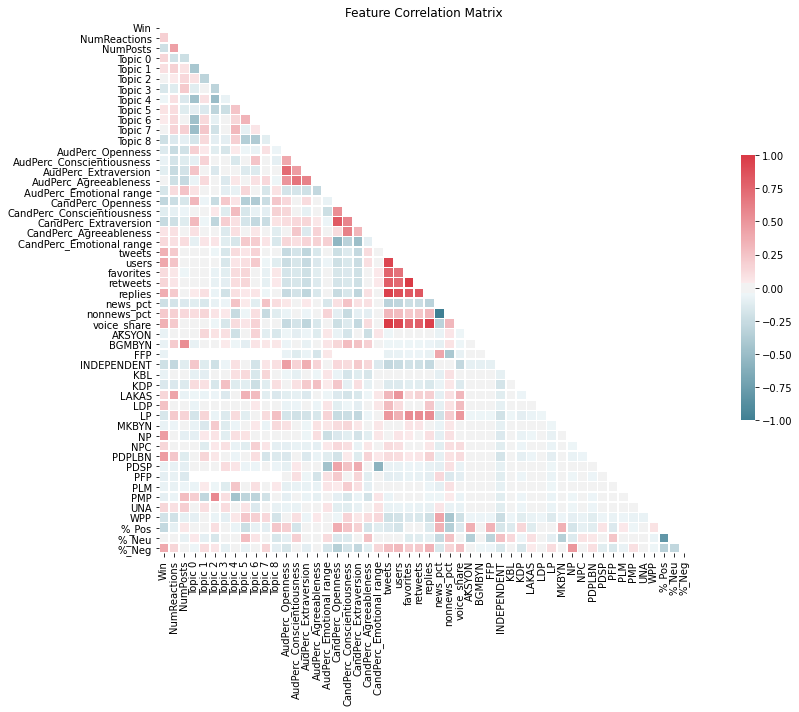

In [ ]:
# Compute the correlation matrix
corr = df_merged.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Matrix')
plt.tight_layout()

# plt.savefig('figures/corr_matrix.png', dpi=200, bbox_inches = "tight")

### 2. Pre-process Data

- Replace nan values - 11/62 rows have NaN values

In [ ]:
for col in df_merged.columns[2:]:
    df_merged[col].fillna(df_merged[col].median(), inplace=True) ##fillna with median values

In [ ]:
df_merged

,Candidate,Win,NumReactions,NumPosts,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,...,PDPLBN,PDSP,PFP,PLM,PMP,UNA,WPP,%_Pos,%_Neu,%_Neg
0,Vangie Abejo,0,97.0,21.0,0.160624,0.087002,0.105881,0.112805,0.109497,0.118678,...,0,0,0,0,0,0,0,41.666667,41.666667,16.666667
1,Abner Afuang,0,6834.0,77.0,0.118262,0.114660,0.103341,0.116934,0.110466,0.111504,...,0,0,0,0,0,0,1,43.000000,36.000000,21.000000
2,Freddie Aguilar,0,25375.0,44.0,0.111111,0.109015,0.109835,0.111856,0.110180,0.111111,...,0,0,0,0,0,0,0,24.384525,63.892145,11.723329
3,Shariff Albani,0,5107.0,94.0,0.107929,0.107806,0.110267,0.118987,0.104358,0.115493,...,0,0,0,0,0,0,1,56.756757,39.639640,3.603604
4,Gary Alejano,0,100413.0,41.0,0.108609,0.122029,0.103802,0.098511,0.108589,0.102230,...,0,0,0,0,0,0,0,48.098455,36.254280,15.647266
5,Richard Alfajora,0,244.0,40.0,0.115109,0.127182,0.105676,0.103846,0.109308,0.108955,...,0,0,0,0,0,0,0,44.897959,36.734694,18.367347
6,Raffy Alunan,0,359657.0,255.0,0.109101,0.110680,0.110451,0.114484,0.108688,0.106741,...,0,0,0,0,0,0,0,45.261984,43.032330,11.705686
7,Sonny Angara,1,106101.0,55.0,0.110051,0.108048,0.111838,0.114005,0.111272,0.109827,...,0,0,0,0,0,0,0,42.607533,41.089416,16.303051
8,Bam Aquino,0,54915.0,62.0,0.110790,0.109343,0.110483,0.111499,0.106168,0.108620,...,0,0,0,0,0,0,0,43.030667,42.068551,14.900782
9,Gerald Arcega,0,387.0,48.0,0.110413,0.106985,0.109835,0.109158,0.109008,0.113034,...,0,0,0,0,0,0,1,44.943820,21.348315,33.707865


##### Balance Data

Using SMOTE

In [ ]:
# Separate input features (X) and target variable (y)
X = df_merged.iloc[:,2:]
y = df_merged.iloc[:,1]

In [ ]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Win'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of Losers in oversampled data",len(os_data_y[os_data_y['Win']==0]))
print("Number of Winners",len(os_data_y[os_data_y['Win']==1]))
print("Proportion of Losers data in oversampled data is ",len(os_data_y[os_data_y['Win']==0])/len(os_data_X))
print("Proportion of Winners data in oversampled data is ",len(os_data_y[os_data_y['Win']==1])/len(os_data_X))

length of oversampled data is  78
Number of Losers in oversampled data 39
Number of Winners 39
Proportion of Losers data in oversampled data is  0.5
Proportion of Winners data in oversampled data is  0.5


### 3. Model Selection

Train & test models at default conditions. Select the model with highest accuracy.

##### 1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

#not sure if need scaling
scale = preprocessing.StandardScaler()
scale.fit(os_data_X)
X_scaled = scale.transform(os_data_X)

# Train model
clf_1 = LogisticRegression().fit(os_data_X, os_data_y)
 
# Predict on training set
pred_y_1 = clf_1.predict(os_data_X)

# print classification report 
print(classification_report(os_data_y, pred_y_1)) 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.95      1.00      0.97        39

    accuracy                           0.97        78
   macro avg       0.98      0.97      0.97        78
weighted avg       0.98      0.97      0.97        78

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Test

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.62      1.00      0.77         5

    accuracy                           0.81        16
   macro avg       0.81      0.86      0.81        16
weighted avg       0.88      0.81      0.82        16



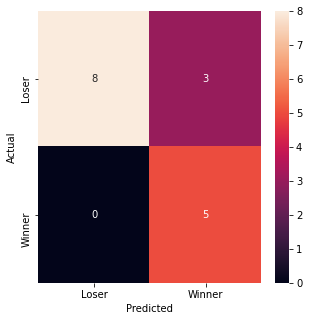

In [ ]:
X_test_scaled = scale.transform(X_test)
predictions = clf_1.predict(X_test_scaled) 
  
# print classification report 
print(classification_report(y_test, predictions)) 


import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Loser','Winner'], yticklabels=['Loser','Winner'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

scale = preprocessing.StandardScaler()
scale.fit(os_data_X)
X_scaled = scale.transform(os_data_X)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_scaled,os_data_y)

# Predict on training set
pred_y_1 = rf_clf.predict(X_scaled)

# print classification report 
print(classification_report(os_data_y, pred_y_1)) 

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



Test

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.60      0.75         5

    accuracy                           0.88        16
   macro avg       0.92      0.80      0.83        16
weighted avg       0.89      0.88      0.86        16



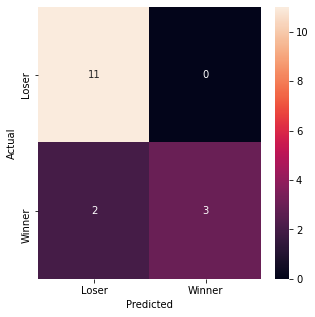

In [ ]:
X_test_scaled = scale.transform(X_test)

preds = rf_clf.predict(X_test_scaled)

# print classification report 
print(classification_report(y_test, preds)) 


import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Loser','Winner'], yticklabels=['Loser','Winner'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 3. XGBoost

In [ ]:
from xgboost import XGBClassifier

scale = preprocessing.StandardScaler()
scale.fit(os_data_X)
X_scaled = scale.transform(os_data_X)

# fit model no training data
model = XGBClassifier()
model.fit(X_scaled, os_data_y)

# Predict on training set
pred_y_1 = model.predict(X_scaled)

# print classification report 
print(classification_report(os_data_y, pred_y_1)) 


/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



Test

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.25      0.20      0.22         5

    accuracy                           0.56        16
   macro avg       0.46      0.46      0.46        16
weighted avg       0.54      0.56      0.55        16



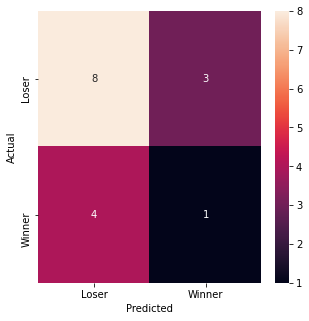

In [ ]:
X_test_scaled = scale.transform(X_test)

preds = model.predict(X_test_scaled)

# print classification report 
print(classification_report(y_test, preds)) 


import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Loser','Winner'], yticklabels=['Loser','Winner'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Random Forest & Logistic Regression have the same accuracy at default conditions.

#### Tune models

Tune models and pick one with the higher accuracy on training data.

##### 1. Logistic Regression

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scaled, os_data_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918452 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.910714 (0.098457) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.910714 (0.098457) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.905952 (0.097474) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.906548 (0.102445) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.906548 (0.102445) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.914881 (0.088410) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.902381 (0.101092) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.902381 (0.101092) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.902381 (0.101092) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.902381 (0.101092) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.902381 (0.101092) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.902381 (0.101092) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.914286 (0.090515) wi

##### 2. Random Forest

In [ ]:
model = RandomForestClassifier(random_state=0)

n_estimators = [10, 20, 50]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scaled, os_data_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.977381 using {'max_features': 'sqrt', 'n_estimators': 50}
0.961310 (0.059240) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.973214 (0.053720) with: {'max_features': 'sqrt', 'n_estimators': 20}
0.977381 (0.050704) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.955952 (0.072570) with: {'max_features': 'log2', 'n_estimators': 10}
0.969048 (0.064867) with: {'max_features': 'log2', 'n_estimators': 20}
0.973214 (0.053720) with: {'max_features': 'log2', 'n_estimators': 50}
/opt/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Random Forest has higher accuracy after tuning. We'll use it as the final model.

### 4. Build Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

scale = preprocessing.StandardScaler()
scale.fit(os_data_X)
X_scaled = scale.transform(os_data_X)

rf_clf = RandomForestClassifier(max_features='sqrt', n_estimators = 20, random_state=0)
rf_clf.fit(X_scaled,os_data_y)

# Predict on training set
pred_y_1 = rf_clf.predict(X_scaled)

# print classification report 
print(classification_report(os_data_y, pred_y_1)) 

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.80      0.89         5

    accuracy                           0.94        16
   macro avg       0.96      0.90      0.92        16
weighted avg       0.94      0.94      0.94        16



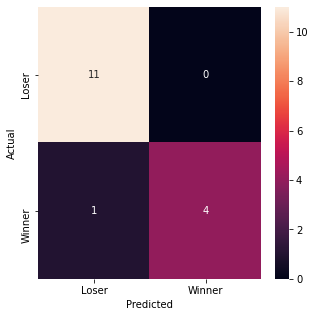

In [ ]:
X_test_scaled = scale.transform(X_test)

preds = rf_clf.predict(X_test_scaled)

# print classification report 
print(classification_report(y_test, preds)) 


import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Loser','Winner'], yticklabels=['Loser','Winner'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Visualizing estimators

In [ ]:
est_l = rf_clf.estimators_

In [ ]:
from sklearn.tree import export_graphviz
from subprocess import call

for i in range(len(est_l)):
    export_graphviz(est_l[i], out_file='tree'+str(i)+'.dot', feature_names=os_data_X.columns)
    call(['dot', '-Tpng', 'tree'+str(i)+'.dot', '-o', 'tree'+str(i)+'.png', '-Gdpi=600'])

#### Feature Importance

In [ ]:
importance = rf_clf.feature_importances_

Text(0, 0.5, 'Feature importance')

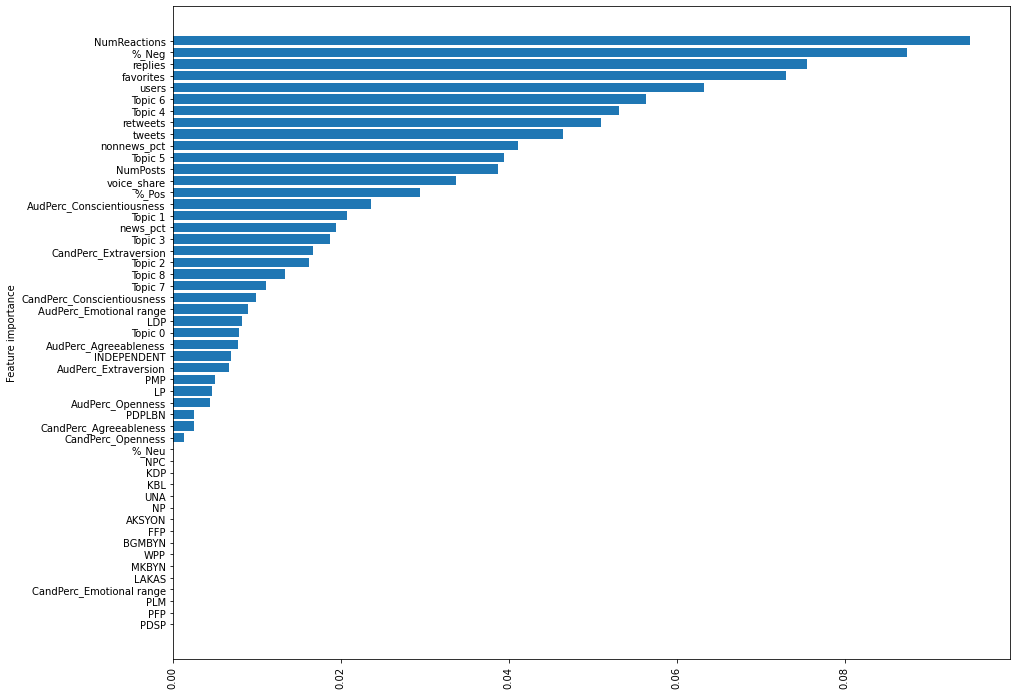

In [ ]:
df_feature = pd.DataFrame(columns=['Feature', 'Importance'])
df_feature['Feature'] = os_data_X.columns
df_feature['Importance'] = importance
df_feature.sort_values('Importance',ascending=True,inplace=True)
plt.figure(figsize=(15,12))
plt.barh(df_feature['Feature'], df_feature['Importance'])
plt.xticks(rotation=90)
plt.ylabel('Feature importance')